In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
from sklearn.model_selection import train_test_split
from pycaret.regression import *
from skorch import NeuralNetRegressor
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.pipeline import Pipeline
from skorch.helper import DataFrameTransformer
warnings.simplefilter('ignore')

## Prepare data

In [2]:
red_train = pd.read_csv("data/winequality-red_train.csv")
white_train = pd.read_csv("data/winequality-white_train.csv")
red_goal = pd.read_csv("data/winequality-red_goal.csv")
white_goal = pd.read_csv("data/winequality-white_goal.csv")

red_goal.drop(columns='quality', inplace=True)
white_goal.drop(columns='quality', inplace=True)

#combine training data for simpler training
#red(0) white(1)
red_train_c = red_train.copy()
red_train_c['color'] = 0
white_train_c = white_train.copy()
white_train_c['color'] = 1
df = pd.concat([red_train_c, white_train_c], ignore_index=True)
df.drop(columns='color', inplace=True) #By feature importance
df['quality'] = df['quality'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5198 entries, 0 to 5197
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         5198 non-null   float64
 1   volatile acidity      5198 non-null   float64
 2   citric acid           5198 non-null   float64
 3   residual sugar        5198 non-null   float64
 4   chlorides             5198 non-null   float64
 5   free sulfur dioxide   5198 non-null   float64
 6   total sulfur dioxide  5198 non-null   float64
 7   density               5198 non-null   float64
 8   pH                    5198 non-null   float64
 9   sulphates             5198 non-null   float64
 10  alcohol               5198 non-null   float64
 11  quality               5198 non-null   float64
dtypes: float64(12)
memory usage: 487.4 KB


In [8]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,6.9,0.670,0.06,2.1,0.080,8.0,33.0,0.99845,3.68,0.71,9.6,5.0
1,7.5,0.530,0.06,2.6,0.086,20.0,44.0,0.99650,3.38,0.59,10.7,6.0
2,11.1,0.180,0.48,1.5,0.068,7.0,15.0,0.99730,3.22,0.64,10.1,6.0
3,8.3,0.705,0.12,2.6,0.092,12.0,28.0,0.99940,3.51,0.72,10.0,5.0
4,7.4,0.670,0.12,1.6,0.186,5.0,21.0,0.99600,3.39,0.54,9.5,5.0


In [ ]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,6.9,0.670,0.06,2.1,0.080,8.0,33.0,0.99845,3.68,0.71,9.6,5.0
1,7.5,0.530,0.06,2.6,0.086,20.0,44.0,0.99650,3.38,0.59,10.7,6.0
2,11.1,0.180,0.48,1.5,0.068,7.0,15.0,0.99730,3.22,0.64,10.1,6.0
3,8.3,0.705,0.12,2.6,0.092,12.0,28.0,0.99940,3.51,0.72,10.0,5.0
4,7.4,0.670,0.12,1.6,0.186,5.0,21.0,0.99600,3.39,0.54,9.5,5.0


In [3]:
#split data for training and validating
train_data, test_data = train_test_split(df, test_size=0.2, random_state=123, stratify=df['quality'])

## Training

In [4]:
from pycaret.regression import *

setup = setup(
    data=train_data,
    target="quality",
    train_size=0.8,
    fold=10,
    fold_strategy='stratifiedkfold',
    fold_shuffle=True,
    #normalize=True,
    #remove_outliers=True,
    #pca=True,
    #use_gpu=True,
    session_id=123,
)

,Description,Value
0,Session id,123
1,Target,quality
2,Target type,Regression
3,Original data shape,"(4158, 12)"
4,Transformed data shape,"(4158, 12)"
5,Transformed train set shape,"(3326, 12)"
6,Transformed test set shape,"(832, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


In [5]:
# 定義 PyTorch 神經網路模型（回歸版本）
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)  # 輸出1個數值，用來預測 quality
    
    def forward(self, X):  # 改為 X 來與 Skorch 和 PyCaret 兼容
        x = self.relu(self.fc1(X))
        x = self.fc2(x)  # 不需要 softmax，回歸問題不需要分類
        return x

# 用 Skorch 包裝 PyTorch 模型，並指定訓練使用 GPU（如果有）
net = NeuralNetRegressor(
    SimpleNN,
    module__input_dim=len(df.columns)-1,  # 除去 target
    module__hidden_dim=64,  # 可以調整隱藏層大小
    max_epochs=50,
    lr=0.01,
    optimizer=optim.Adam,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

nn_pipe = Pipeline(
    [
        ("transform", DataFrameTransformer()),
        ("net", net),
    ]
)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetRegressor
from sklearn.pipeline import Pipeline

# 定義 PyTorch 神經網路模型（回歸版本）
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)  # 輸出1個數值，用來預測 quality

    def forward(self, X):  # 改為 X 來與 Skorch 和 PyCaret 兼容
        x = self.relu(self.fc1(X))
        x = self.fc2(x)  # 回歸問題不需要 softmax
        return x

# 定義新的 Net Regressor 子類，以處理 target y 的維度問題
class AdaptedNetRegressor(NeuralNetRegressor):
    def fit(self, X, y):
        # 將 y 轉換為 NumPy 陣列（即使它原本是 pandas Series）
        y = np.asarray(y)
        # 如果 y 為一維，則轉換成二維（n_samples, 1）
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        return super().fit(X, y)


# 用 AdaptedNetRegressor 包裝 PyTorch 模型，並指定使用 GPU（如果有）
net = AdaptedNetRegressor(
    SimpleNN,
    module__input_dim=len(df.columns) - 1,  # 除去 target 的欄位
    module__hidden_dim=64,  # 隱藏層大小可調
    max_epochs=50,
    lr=0.01,
    optimizer=optim.Adam,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# 假設 DataFrameTransformer 是你定義好的轉換器，用來處理 DataFrame 數據
nn_pipe = Pipeline(
    [
        ("transform", DataFrameTransformer()),
        ("net", net),
    ]
)

In [7]:
tuned_nn_pipe = tune_model(
    nn_pipe,
    custom_grid = {
        'net__lr': [0.001, 0.01, 0.1],
        'net__max_epochs': [50, 100],
        'net__batch_size': [32, 64],
        'net__optimizer__weight_decay': [0, 1e-4, 1e-3],
        'net__module__hidden_dim': [32, 64, 128],
    },
    optimize="RMSE"  # 可根據需求調整評估指標
)


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,23:04:14
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        6.1231        2.6057  102.2063
  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1       19.5849        5.7781  102.2145
  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1      616.6227        7.7187  102.2193
  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1       10.4116        2.6155  102.2220
  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1     1268.2392       36.0771  102.2195
  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1      712.9501        6.3180  102.2071
  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1      778.

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGBUS(-7)}

In [ ]:
# 建立 Skorch 模型
nn_model = create_model(nn_pipe)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5745,0.5736,0.7574,0.2706,0.1141,0.1038
1,0.5686,0.5378,0.7334,0.3162,0.1115,0.1024
2,0.5593,0.5056,0.7111,0.3571,0.1060,0.0993
3,0.5861,0.5893,0.7676,0.2694,0.1127,0.1012
4,0.5920,0.5590,0.7477,0.3069,0.1114,0.1052
5,0.5911,0.5637,0.7508,0.3080,0.1148,0.1094
6,0.5600,0.5014,0.7081,0.3545,0.1059,0.1000
7,0.5923,0.6023,0.7761,0.2246,0.1145,0.1009
8,0.6091,0.5914,0.7691,0.2521,0.1155,0.1093


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       79.3732       13.9179  0.6637
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       12.5271        2.3563  0.6270
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       19.8830        4.8926  0.5877
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       34.7716        1.7735  0.6666
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        5.6823        1.9072  0.6765
  epoch    train_loss    valid_loss     dur  epoch    train_loss    valid_loss     dur

-------  ------------  ------------  ------
-------  ------------  ------------  ------
      1       11.8539        2.5463  0.6504
      1       21.2946        4.6413  0.6049
  epoch    train_loss    valid_loss     dur
-------  ------------  ---------

In [ ]:
custom_grid = {
    'module__hidden_dim': [32, 64, 128],  # 隱藏層大小
    'lr': [0.001, 0.01, 0.1],  # 學習率
    'batch_size': [16, 32, 64],  # Batch 大小
    'max_epochs': [30, 50]  # 訓練的 epoch 數
}

nn_model = tune_model(nn_model, custom_grid=custom_grid)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:45:13
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,NeuralNetRegressor


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


ValueError: Invalid parameter 'actual_estimator' for estimator Pipeline(steps=[('transform', DataFrameTransformer()),
                ('net',
                 NeuralNetRegressor(_params_to_validate={'module__hidden_dim', 'module__input_dim'}, batch_size=128, callbacks=None, compile=False, dataset=<class 'skorch.dataset.Dataset'>, device='cuda', iterator_train=<class 'torch.utils.data.dataloader.DataLoader'>, iterator_valid=<class 'torch.utils.data.dataloader.DataLoader'>, lr=0.01, max_epochs=50, module=<class '__main__.SimpleNN'>, module__hidden_dim=64, module__input_dim=11, optimizer=<class 'torch.optim.adam.Adam'>, predict_nonlinearity='auto', torch_load_kwargs=None, train_split=<skorch.dataset.ValidSplit object at 0x7f3d6c3a9e40>, use_caching='auto', verbose=1, warm_start=False))]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [ ]:
model = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4166,0.3905,0.6249,0.5035,0.0968,0.0772
1,0.4368,0.4037,0.6354,0.4867,0.0981,0.0802
2,0.4061,0.3658,0.6048,0.5350,0.0931,0.0744
3,0.4423,0.4282,0.6544,0.4690,0.0994,0.0802
4,0.4415,0.4240,0.6511,0.4743,0.0984,0.0802
5,0.4420,0.4040,0.6356,0.5041,0.0968,0.0799
6,0.4055,0.3608,0.6007,0.5355,0.0908,0.0733
7,0.4099,0.3598,0.5998,0.5368,0.0910,0.0734
8,0.4220,0.3821,0.6181,0.5169,0.0946,0.0769


In [ ]:
model = finalize_model(model)
evaluate_model(model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
predictions = predict_model(model, data=test_data)
print(predictions.head())

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.4027,0.4027,0.6346,0.4940,0.0959,0.0733


      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
4700            7.7              0.46         0.18             3.3      0.054   
2894            7.0              0.29         0.49             3.8      0.047   
4834            7.2              0.31         0.35             7.2      0.046   
4676            6.6              0.18         0.28             1.7      0.041   
5114            7.4              0.34         0.28            12.1      0.049   

      free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
4700                 18.0                 143.0  0.99392  3.12       0.51   
2894                 37.0                 136.0  0.99380  2.95       0.40   
4834                 45.0                 178.0  0.99550  3.14       0.53   
4676                 53.0                 161.0  0.99207  3.13       0.45   
5114                 31.0                 149.0  0.99677  3.22       0.49   

      alcohol  quality  prediction_label  
4700   

In [ ]:
r_pred = predict_model(model, data=red_goal)
w_pred = predict_model(model, data=white_goal)

red_goal['quality'] = r_pred['prediction_label'].round().astype(int)
white_goal['quality'] = w_pred['prediction_label'].round().astype(int)

array([[<Axes: title={'center': 'quality'}>, <Axes: >]], dtype=object)

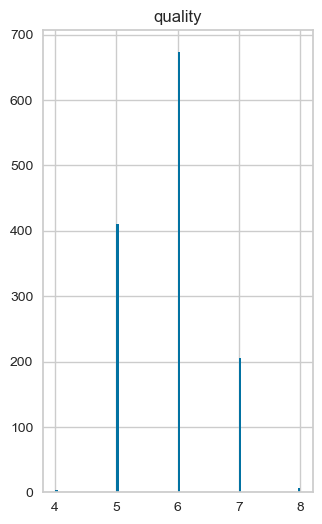

In [ ]:
r_df = red_goal.copy()
w_df = white_goal.copy()

r_df['ID'] = ['red_' + str(i + 1) for i in range(len(r_df))]
w_df['ID'] = ['white_' + str(i + 1) for i in range(len(w_df))]

r_final = r_df[['ID', 'quality']]
w_final = w_df[['ID', 'quality']]

combined_df = pd.concat([r_final, w_final], ignore_index=True)
combined_df.to_csv("combined_predictions.csv", index=False)

combined_df.hist(layout=(1, 2), figsize=(8, 6), bins=100)